# Multi-Arc Impedance Analysis# 

This notebook summarizes the attempt to apply the series connection of a series resistance $R_{s}$, an $RC/RQ$ arc, and a Randles circuit with **normal** diffusion to PbS-TBAI/ZnO impedance data that shows multiple arcs. At the moment, I believe that these separate arcs are due to the charge responses in these different layers: the $RC/RQ$ arc seems likely to emerge due to low frequency charge dynamics in the PbS, whereas the high frequency arc that becomes more prominent at high temperatures results from charge motion in the ZnO. In addition to the ample evidence from TAS that we have for drawing this distinction (which I should start summarizing...), this also matches our physical intuition--if the ZnO is indeed more heavily doped then not only should it contain an $RC/RQ$ arc due to recombination, but also a diffusion part that comes from  minority carrier diffusion to the electrode.

So, let's start the analysis. A catalog of potential models can be found in 'newData2_multiArc_Catalog.ipynb', so hopefully I won't have to spend too much time messing with different fits. Instead, let's try and run a temperature-dependent analysis, and see if we can extract lifetimes. I mostly care about the temperature dependence of $\tau$, but will obviously consider the temperature-depdnence of most of the fit parameters. 



In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [3]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
%matplotlib inline

os.chdir('C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\ZnO_2\\dev2\\data')

# os.listdir()
tmax = 16
T = np.linspace(180,180+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 400
voltage2 = 500

nPoints = 201
master400mv = np.zeros((tmax,nPoints,5))
master500mv = np.zeros((tmax,nPoints,5))

is400 = np.zeros((tmax,nPoints,4))
is500 = np.zeros((tmax,nPoints,4))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master400mv[t,:,0] = tmp1[1:,0]
    master400mv[t,:,1] = savitzky_golay(tmp1[1:,1],51,5)
    master400mv[t,:,2] = savitzky_golay(tmp1[1:,2],51,5)
    master400mv[t,:,3] = savitzky_golay(tmp1[1:,3],51,5)
    master400mv[t,:,4] = savitzky_golay(tmp1[1:,4],51,5)

    is400[t,:,0] = ((master400mv[t,:,4]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,1] = ((-master400mv[t,:,2]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,2] = np.sqrt((is400[t,:,0]**2) + (is400[t,:,1]**2))
    is400[t,:,3] = -np.arctan(is400[t,:,1]/is400[t,:,0])*(180/np.pi)
                           
        
    file2 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage2) + 'mV_All_Modified.txt'     
    tmp2 = np.genfromtxt(file2)
    master500mv[t,:,0] = tmp2[1:,0]    
    master500mv[t,:,1] = savitzky_golay(tmp2[1:,1],51,5)
    master500mv[t,:,2] = savitzky_golay(tmp2[1:,2],51,5)
    master500mv[t,:,3] = savitzky_golay(tmp2[1:,3],51,5)
    master500mv[t,:,4] = savitzky_golay(tmp2[1:,4],51,5)

    is500[t,:,0] = ((master500mv[t,:,4]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,1] = ((-master500mv[t,:,2]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,2] = np.sqrt((is500[t,:,0]**2) + (is500[t,:,1]**2))
    is500[t,:,3] = -np.arctan(is500[t,:,1]/is500[t,:,0])*(180/np.pi)
    


# define some simple functions to make the analysis code a bit more concise
def Zr400(T):
    return is400[T,:,0]

def Zr500(T):
    return is500[T,:,0]

def Zi400(T):
    return is400[T,:,1]

def Zi500(T):
    return is500[T,:,1]

def Zmag400(T):
    return is400[T,:,2]

def Zmag500(T):
    return is500[T,:,2]

def phi400(T):
    return is400[T,:,3]

def phi500(T):
    return is500[T,:,3]

def w(T):
    return master400mv[t,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.plasma(np.linspace(0,1,tmax)))

# indicate the figures directory
figDir = r'C:\Users\Eric\Desktop\Lab_Work\impedance\PbS-TBAI\ZnO_2\dev2\analysis\newModel'

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 1


# Estimate $R_{s}$ by taking the highest frequency value of $Z_{r}$
RsEst400 = np.zeros(tmax)
RsEst500 = np.zeros(tmax)

for t in range (0,tmax): 
    RsEst400[t] = Zr400(t)[-1]
    RsEst500[t] = Zr500(t)[-1]
    
# define functions to output the magnitude and phase angle of the Rs-corrected plots.   
def Zmag400adj(T):
    return np.sqrt(((is400[t,:,0]-RsEst400[t])**2) + (is400[t,:,1]**2))

def Zmag500adj(T):
    return np.sqrt(((is500[t,:,0]-RsEst500[t])**2) + (is500[t,:,1]**2))

def phi400adj(T):
    return -np.arctan(is400[t,:,1]/(is400[t,:,0]-RsEst400[t]))*(180/np.pi)

def phi500aj(T):
    return -np.arctan(is500[t,:,1]/(is500[t,:,0]-RsEst500[t]))*(180/np.pi)

Take a quick look at the 400 mV data, to identify salient features. Note that we are also plotting  the $R_{s}$ correted data.

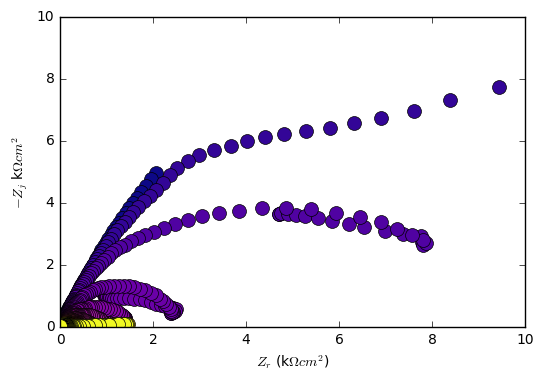

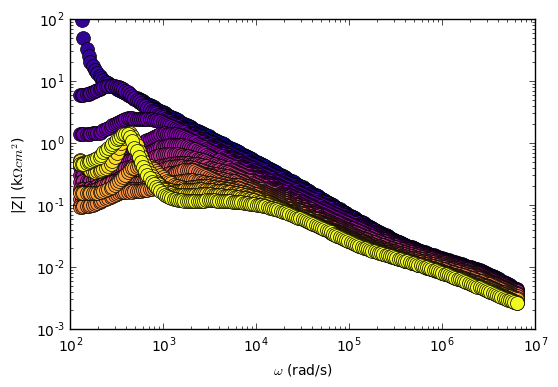

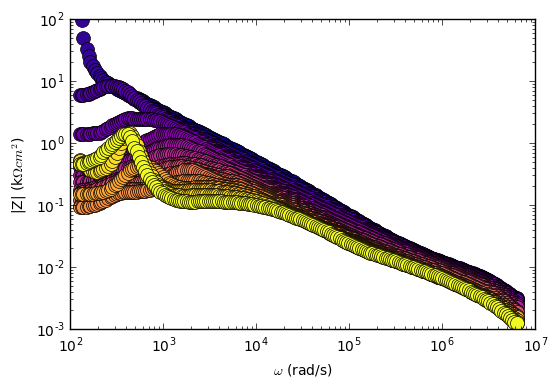

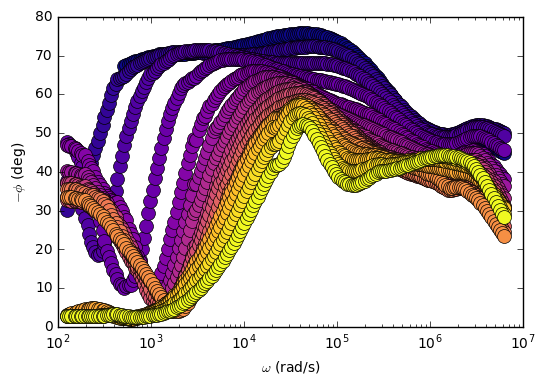

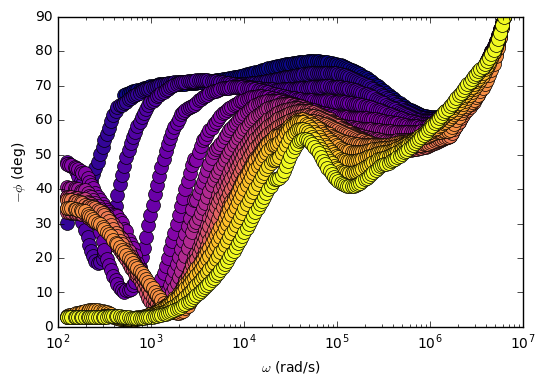

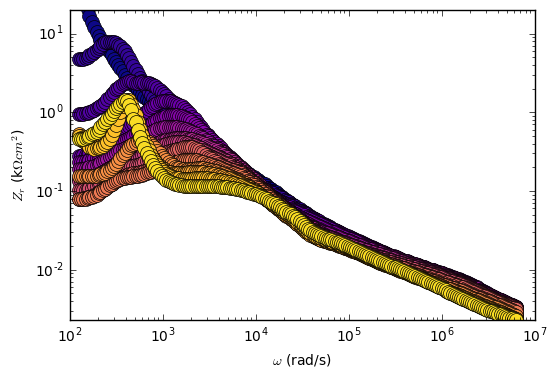

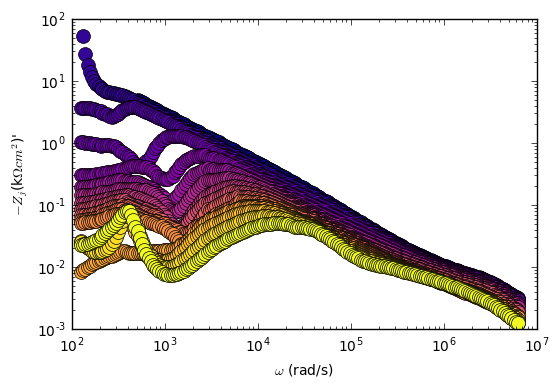

In [4]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(Zr400(t),-Zi400(t),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,10, 0,10])
figName = '\\nyquist_400mV_all.png'
plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmag400(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
figName = '\\magZ_400mV_all.png'
plt.savefig(figDir + figName,dpi = 300)

# |Z|_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Zmag400adj(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("$|Z|_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
figName = '\\magZadj_400mV_all.png'
plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phi400(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
figName = '\\phase_400mV_all.png'
plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),phi400adj(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
figName = '\\phaseAdj_400mV_all.png'
plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zr400(t),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([0,2e1]);
figName = '\\reZ_400mV_all.png'
plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),abs(-Zi400(t)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
figName = '\\imZ_400mV_all.png'
plt.savefig(figDir + figName,dpi = 300)

So, nothing too suprising here. It bodes well for our model! 

From the look of the adjusted phase angle plot, there are 2 inflection points: one at low frequency $\sim 1 \times  10^{3} < \omega <  \sim 4 \times 10^{4}$, and one at high frequencies $\sim 2 \times  10^{5} < \omega <  \sim 4 \times 10^{6}$. Seems to fit well with our equivalent circuit!

Continuing the analysis, let's check the offsets, etc. 

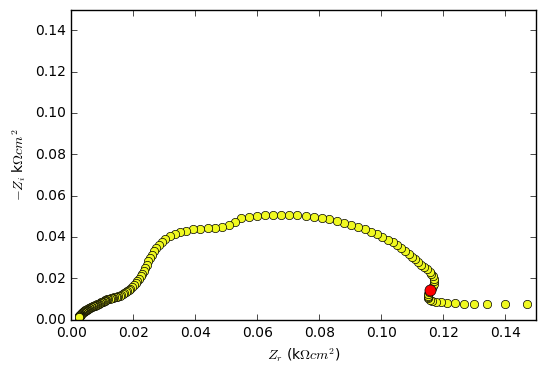

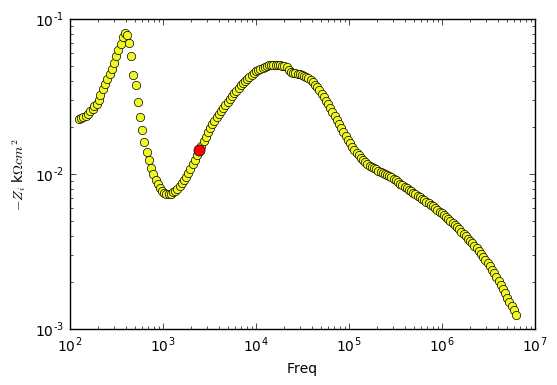

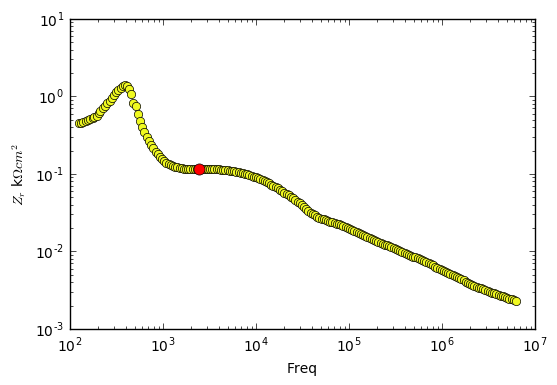

In [5]:
# clumsy way of ID-ing physically reasonable range of fit

bounds = np.zeros(tmax)

Tt = 15
offGuess = 55
# offSet = 2


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt),-Zi400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr400(Tt)[offGuess],-Zi400(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.15, 0,.15])

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[offGuess],-Zi400(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Zr400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[offGuess],Zr400(Tt)[offGuess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$Z_{r}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

bounds[0] = 26
bounds[1] = 26
bounds[2] = 26
bounds[3] = 30
bounds[4] = 45
bounds[5] = 48
bounds[6] = 53
bounds[7] = 53
bounds[8] = 59
bounds[9] = 60
bounds[10] = 70
bounds[11] = 60
bounds[12] = 55
bounds[13] = 55
bounds[14] = 55
bounds[15] = 55

With our offsets set, let's go ahead and make the guesses. 

Note that we are using a quick and dirty method to gain estimates for the parameters. Note that we are starting with high temperature data, since the reactive arc features are most apparent at high $T$.

Also note that we are not provided a guess for $\alpha$. We can of course provide one by fitting the slope of one side of the peak, but let's see if we can get away with not doing that since it takes a while.

114
101
101
101
0.0167560096944 0.0614428372308
0.00137777482409 0.00123523738083


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


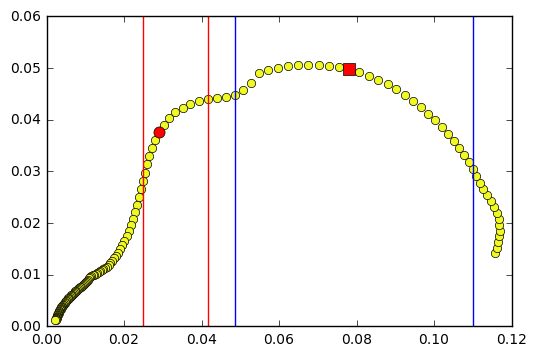

In [9]:
Tt = 15

# define a function that allows us to get the index of values read off the Nyquist plot so we know where to bound 
# the function in frequency
def ZrIdx(T,val):
    return max(np.where(Zr400(T) <= val))[0]


zbound1 = ZrIdx(Tt,0.025)
print(zbound1)

zbound2 = ZrIdx(Tt,0.043)
print(zbound2)

zbound3 = ZrIdx(Tt,0.05)
print(zbound2)

zbound4 = ZrIdx(Tt,0.11)
print(zbound2)

# guesses for charge transfer resistance based on arc radii. 1 is for high freq CPE, 2 is for low freq
guessRct1 = Zr400(Tt)[zbound2] - Zr400(Tt)[zbound1] 
guessRct2 = Zr400(Tt)[zbound4] - Zr400(Tt)[zbound3] 

print(guessRct1, guessRct2)

w0gIdx1 = ZrIdx(Tt,.03)
w0guess1 = w(Tt)[w0gIdx1]

w0gIdx2 = ZrIdx(Tt,.08)
w0guess2 = w(Tt)[w0gIdx2]

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))

plt.axvline(Zr400(Tt)[zbound1],color = 'r')
plt.axvline(Zr400(Tt)[zbound2], color = 'r')

plt.axvline(Zr400(Tt)[zbound3])
plt.axvline(Zr400(Tt)[zbound4])

ax.plot(Zr400(Tt)[w0gIdx1],-Zi400(Tt)[w0gIdx1],'ro', markersize = 8)
ax.plot(Zr400(Tt)[w0gIdx2],-Zi400(Tt)[w0gIdx2],'rs', markersize = 8)

# guess for Q based on peak freq of each arc and Rct guesses above. 
guessQ1 = 1/(guessRct1*w0guess1)
guessQ2 = 1/(guessRct2*w0guess2)

print(guessQ1,guessQ2)


In [10]:
# define functions for the impedance of all circuit elements used in the analysis


# define a function for the impedance of a single RQ arc t
def arc(w,Rct,Q,alpha):
    return Rct/(1+((1j*w)**alpha)*Q*Rct)

# define a function for the impedance of normal Warbug diffusion
def Zd(w,z0,td):
    return z0*(np.tanh(np.sqrt(1j*w*td))/np.sqrt(1j*w*td))

# define a function for the impedance of aCPE 
def cpe(w,Q,alpha):
    return 1/(((1j*w)**alpha)*Q)

# define a function for the impedance of a series resistor
def seriesR(w,c):
    return c

# define a function for the composite impedance of a normal Randles circuit
def randlesZ_finite(w,Rct,Q,alpha,z0,td):
    return (Rct +  Zd(w,z0,td) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Zd(w,z0,td)))

#define a function for impedance due to anomalous diffusion as defined by Bisquert, et. al. just in case we need it 
def Za(w,z0,td,alpha):
    return z0*(np.tanh((1j*w*td)**(alpha/2))/((1j*w*td)**(alpha/2)))

#define a function for impedance of a complete Randles circuit with anomalous diffusion as defined by Bisquert, et. al.
def randlesZ_finite_anom(w,Rct,Q,alpha,z0,td):
    return (Rct +  Za(w,z0,td,alpha) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Za(w,z0,td,alpha)))


from lmfit import Model
 


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[[Model]]
    ((Model(seriesR, prefix='Rs_') + Model(arc, prefix='a1_')) + Model(randlesZ_finite, prefix='r_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 271
    # data points      = 292
    # variables        = 9
    chi-square         = 4.3768e-04
    reduced chi-square = 1.5466e-06
    Akaike info crit   = -3897.94710
    Bayesian info crit = -3864.85631
[[Variables]]
    Rs_c:      0.00315351 +/- 3.4381e-04 (10.90%) (init = 0.003)
    a1_Rct:    0.01242490 +/- 0.00113098 (9.10%) (init = 0.01675601)
    a1_Q:      4.4613e-04 +/- 2.9012e-04 (65.03%) (init = 0.0006)
    a1_alpha:  0.92022152 +/- 0.05146262 (5.59%) (init = 0.9)
    r_Rct:     0.09632603 +/- 0.00656188 (6.81%) (init = 0.06144284)
    r_z0:      0.00777183 +/- 0.00635017 (81.71%) (init = 1e-05)
    r_td:      1.3152e-04 +/- 6.2460e-05 (47.49%) (init = 0.0001)
    r_Q:       5.6686e-04 +/- 8.7900e-05 (15.51%) (init = 0.0004)
    r_alpha:   0.99999998 +/- 0.01511986 (1.51%) (init = 0.95)


AttributeError: 'GridSpec' object has no attribute 'set_xscale'

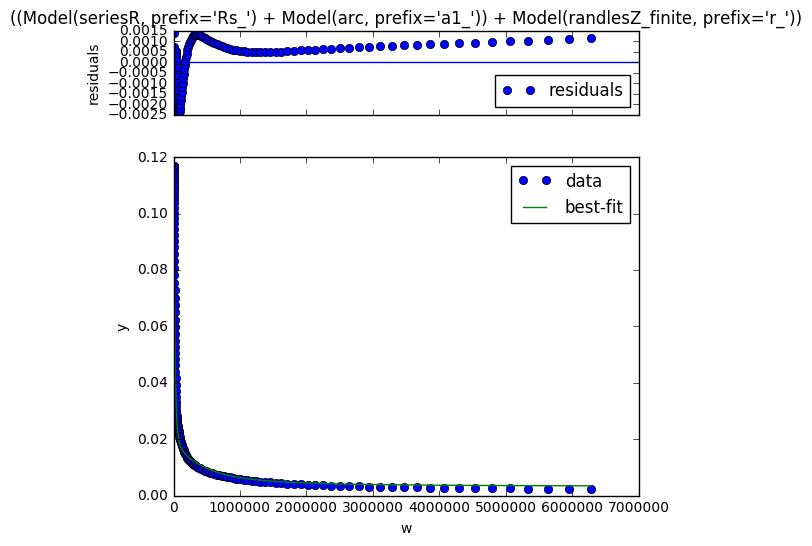

In [56]:
# define and run the aggregate model. Note that we are initially running it for Tt, define above.

# define models for the circuit elements to be added in series
randles_norm = Model(randlesZ_finite, prefix = 'r_')
arc1 = Model(arc,prefix = 'a1_')
Rs = Model(seriesR,prefix = 'Rs_')

# define the aggregate moel
aggModel = Rs + arc1 + randles_norm 

# add parameters with guesses
params = lmf.Parameters()  

params.add('Rs_c',value =  .003, min = 0, max = 5)

params.add('a1_Rct',value = guessRct1, min = 0, max = 5)
params.add('a1_Q',value = 6e-4, min = 0, max = 1e-3)
params.add('a1_alpha',value = 0.9, min = 0, max = 1)

params.add('r_Rct',value = guessRct2, min = 0, max = 5)
params.add('r_z0',value = 1e-5, min = 0, max = 10)
params.add('r_td',value = 1e-4, min = 0, max = 1e-3)
params.add('r_Q',value = 4e-4, min = 0, max = 1e-3)
params.add('r_alpha',value = 0.95, min = 0, max = 1)

# make the data complex
data = Zr400(Tt)[bounds[Tt]:]+1j*Zi400(Tt)[bounds[Tt]:]

#try the fit
fit_result = aggModel.fit(data, w = w(Tt)[bounds[Tt]:],params = params)

print(fit_result.fit_report())

# fig,ax = fit_result.plot()
# ax.set_xscale('log')

# make arrays that store the real and imaginary parts for the fit and the magnitude 
fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds[Tt]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


I just had a thought: perhaps what we are seeing is due to a **double layer capacitance**. As drawn in my lab notebook, maybe what we are in fact seeing is the parallel connection of a double layer capacitance with a Randles circuit. This might describe how charge can either build up at the interface *or* transfer through the material and recombine/diffuse.

In this interpretation, the breakdown of the Zno/PbS interface after a few days of air exposure would cause the disappearance of the capacitance, instead increasing the resistance of $R_{s}$. In addition, perhaps the diffusion element largely dissapears because we the film/device simply becomes too shitty to discern any movement of charge.

So, let's define a model, and try the fit.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='RsL_') + Model(doubleLayerDiff))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 546
    # data points      = 292
    # variables        = 9
    chi-square         = 4.4356e-04
    reduced chi-square = 1.5674e-06
    Akaike info crit   = -3894.04833
    Bayesian info crit = -3860.95755
[[Variables]]
    RsL_c:     0.00352785 +/- 3.6466e-04 (10.34%) (init = 0.003)
    Q_dl:      1.3836e-04 +/- 1.3755e-04 (99.41%) (init = 0.0006)
    alpha_dl:  0.99354803 +/- 0.07285369 (7.33%) (init = 0.95)
    Rr:        0.01891102 +/- 0.00309256 (16.35%) (init = 0.003)
    Rct:       0.08815472 +/- 0.01053250 (11.95%) (init = 0.06144284)
    Q_r:       4.6457e-04 +/- 2.3713e-04 (51.04%) (init = 0.0004)
    alpha_r:   0.99999999 +/- 0.07505240 (7.51%) (init = 0.9)
    z0:        0.00913288 +/- 0.00844937 (92.52%) (init = 1e-05)
    td:        1.1941e-04 +/- 4.5371e-05 (38.00%) (init = 0.0001)
[[Correlations]] (unreported correlations ar

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


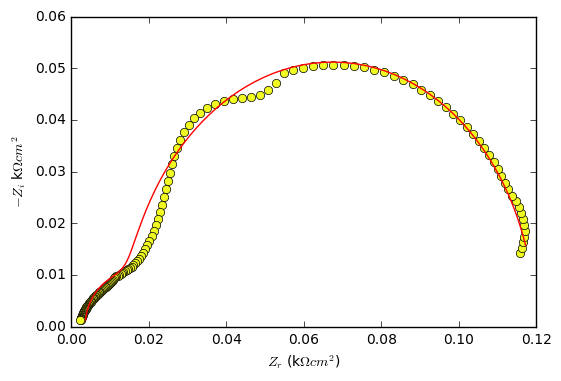

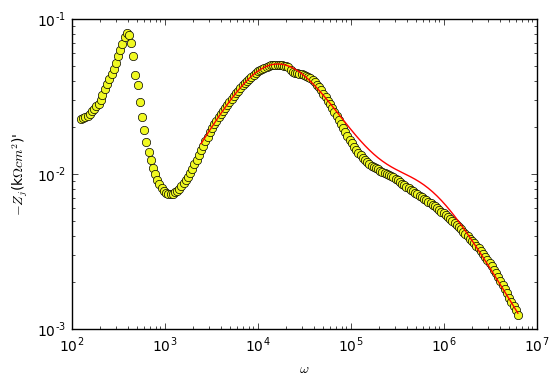

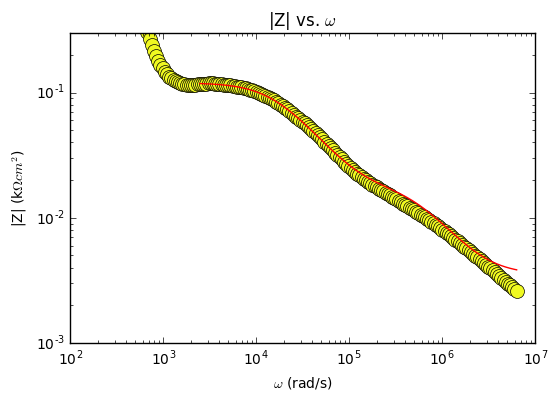

In [40]:
# define a double layer model, using the functions defined above. 

# define a function for the impedance of a Randles circuit plus a leading series resistance Rs
def randlesZ_finite_comp(w,Rr,Rct,Q_r,alpha_r,z0,td):
    return Rr + ((Rct +  Zd(w,z0,td) ) / (1 + ((1j*w)**alpha_r)*Q_r*(Rct + Zd(w,z0,td))))

# define a function for the impedance of a double layer CPE
def cpe_dl(w,Q_dl,alpha_dl):
    return 1/(((1j*w)**alpha_dl)*Q_dl)

# define a function for impedance of the parallel connection of a double layer CPE with a complete Randles circuit
def doubleLayerDiff(w,Q_dl,alpha_dl,Rr,Rct,Q_r,alpha_r,z0,td):
    return (cpe_dl(w,Q_dl,alpha_dl)*randlesZ_finite_comp(w,Rr,Rct,Q_r,alpha_r,z0,td))/(cpe_dl(w,Q_dl,alpha_dl)+randlesZ_finite_comp(w,Rr,Rct,Q_r,alpha_r,z0,td))

# define the aggregate model
RsLead = Model(seriesR,prefix = 'RsL_')
doubleLayer = Model(doubleLayerDiff)

dlModel = RsLead + doubleLayer

# add parameters with guesses
params2 = lmf.Parameters()  

params2.add('RsL_c',value =  .003, min = 0, max = 5)

params2.add('Q_dl',value = 6e-4, min = 0, max = 1e-3)
params2.add('alpha_dl',value = 0.95, min = 0, max = 1)
# params2.add('alpha_dl',value = 1, vary = False)

params2.add('Rr',value = .003, min = 0, max = 5)
params2.add('Rct',value = guessRct2, min = 0, max = 5)
params2.add('Q_r',value = 4e-4, min = 0, max = 1e-3)
params2.add('alpha_r',value = 0.9, min = 0, max = 1)
params2.add('z0',value = 1e-5, min = 0, max = 10)
params2.add('td',value = 1e-4, min = 0, max = 1e-3)


# make the data complex
data = Zr400(Tt)[bounds[Tt]:]+1j*Zi400(Tt)[bounds[Tt]:]

#try the fit
fit_result = dlModel.fit(data, w = w(Tt)[bounds[Tt]:],params = params2)

print(fit_result.fit_report())

fit_result.plot

# make arrays that store the real and imaginary parts for the fit and the magnitude 
fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds[Tt]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)





This looks literally the same as the other one! I bet it's just a matter of interpretation. To discern these models, we probably need to consider some external data. Like, *only* ZnO or another set of solar cell data. 

For completeness, let's just *try* a double layer model without the diffusion element. That is, we can try either 2 or 3 arcs. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='RsL_') + Model(dl_2arc))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 162
    # data points      = 292
    # variables        = 7
    chi-square         = 4.5265e-04
    reduced chi-square = 1.5882e-06
    Akaike info crit   = -3892.12656
    Bayesian info crit = -3866.38929
[[Variables]]
    RsL_c:     0.00332968 +/- 3.5140e-04 (10.55%) (init = 0.003)
    Rct1:      0.09632085 +/- 0.00276957 (2.88%) (init = 0.06144284)
    Q1:        5.0750e-04 +/- 1.7518e-04 (34.52%) (init = 0.0004)
    alpha1:    0.99077377 +/- 0.02757879 (2.78%) (init = 0.9)
    c1:        0.02057101 +/- 0.00322955 (15.70%) (init = 0.003)
    Q_dl:      2.5317e-04 +/- 2.2490e-04 (88.83%) (init = 0.0006)
    alpha_dl:  0.94861585 +/- 0.06517803 (6.87%) (init = 0.95)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q_dl, alpha_dl)   = -0.999
    C(Q1, alpha1)       = -0.998
    C(Q1, Q_dl)         = -0.988
    C(Q1, alpha_dl)     =  0.9

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


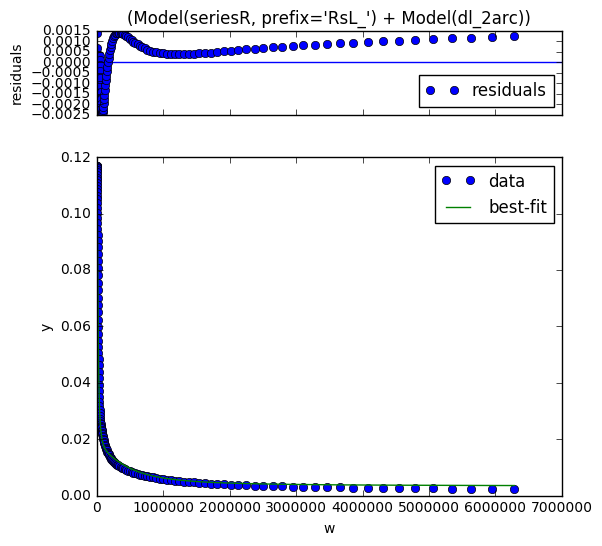

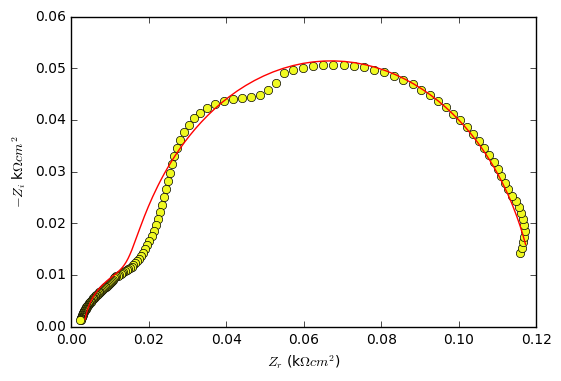

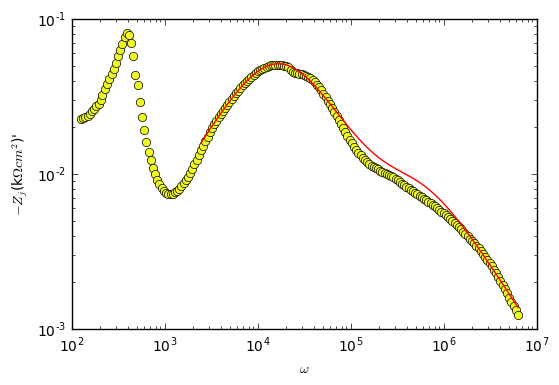

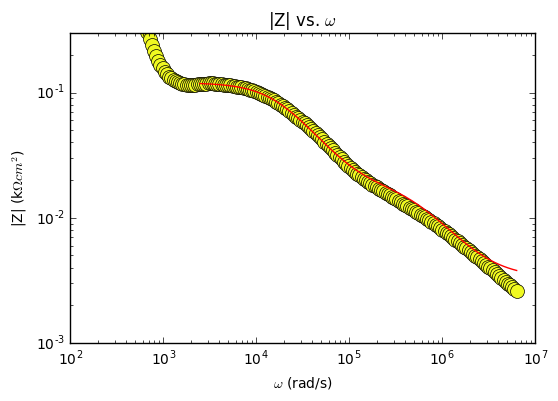

In [58]:
# first try with 2 arcs

# define a function for the imepdance of RQ arc 1 
def arc1(w,Rct1,Q1,alpha1):
    return Rct1/(1+((1j*w)**alpha1)*Q1*Rct1)

# define a function for the impedance for the double layer CPE
def cpe_dl(w,Q_dl,alpha_dl):
    return 1/(((1j*w)**alpha_dl)*Q_dl)

# define a function for the impedance for the series resistor for arc 1
def seriesR1(w,c1):
    return c1

# define a function for the impedance of 1 RC arc embedded in another
def dl_2arc(w,Rct1,Q1,alpha1,c1,Q_dl,alpha_dl):
    return ((seriesR1(w,c1) + arc1(w,Rct1,Q1,alpha1))*cpe_dl(w,Q_dl,alpha_dl))/((seriesR1(w,c1) + arc1(w,Rct1,Q1,alpha1))+cpe_dl(w,Q_dl,alpha_dl)) 

# define the aggregate model
RsLead = Model(seriesR,prefix = 'RsL_')
doubleLayer_2arc = Model(dl_2arc)

dlModel2arc = RsLead + doubleLayer_2arc

# add parameters with guesses
params2 = lmf.Parameters()  

params2.add('RsL_c',value =  .003, min = 0, max = 5)

params2.add('Rct1',value = guessRct2, min = 0, max = 5)
params2.add('Q1',value = 4e-4, min = 0, max = 1e-3)
params2.add('alpha1',value = 0.9, min = 0, max = 1)
params2.add('c1',value = .003, min = 0, max = 5)
params2.add('Q_dl',value = 6e-4, min = 0, max = 1e-3)
params2.add('alpha_dl',value = 0.95, min = 0, max = 1)

# make the data complex
data = Zr400(Tt)[bounds[Tt]:]+1j*Zi400(Tt)[bounds[Tt]:]

#try the fit
fit_result2 = dlModel2arc.fit(data, w = w(Tt)[bounds[Tt]:],params = params2)

print(fit_result2.fit_report())

fit_result2.plot()

# make arrays that store the real and imaginary parts for the fit and the magnitude 
fitMag2 = np.sqrt((np.imag(fit_result2.best_fit))**2 + (np.real(fit_result2.best_fit))**2)
reFit2 = np.real(fit_result2.best_fit)
imFit2 = np.imag(fit_result2.best_fit)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result2.best_fit),-np.imag(fit_result2.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds[Tt]:],abs(imFit2),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],fitMag2, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='RsL_') + Model(dl_3arc))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 492
    # data points      = 292
    # variables        = 10
    chi-square         = 4.4517e-04
    reduced chi-square = 1.5786e-06
    Akaike info crit   = -3890.99252
    Bayesian info crit = -3854.22499
[[Variables]]
    RsL_c:      0.00317312 +/- 7.7563e-04 (24.44%) (init = 0.003)
    c2:         0.01306441 +/- 0.01970777 (150.85%) (init = 0.001)
    Rct1:       0.08835518 +/- 0.02046116 (23.16%) (init = 0.06144284)
    Q1:         4.0696e-04 +/- 7.1315e-04 (175.24%) (init = 0.0004)
    alpha1:     0.98021200 +/- 0.12444049 (12.70%) (init = 0.9)
    c1:         0.01531498 +/- 0.01608316 (105.02%) (init = 0.001)
    Q_dl:       2.6096e-04 +/- 8.6689e-04 (332.19%) (init = 0.0005)
    alpha_dl:   0.98218901 +/- 0.27024735 (27.51%) (init = 0.95)
    Q_dlo:      1.0505e-04 +/- 5.6643e-04 (539.21%) (init = 0.0006)
    alpha_dlo:  0.99999924 +/- 0.36

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:72: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


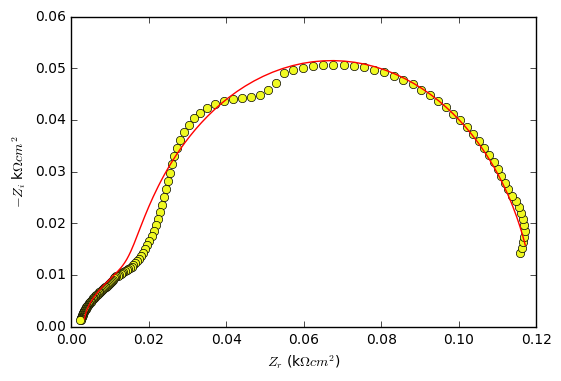

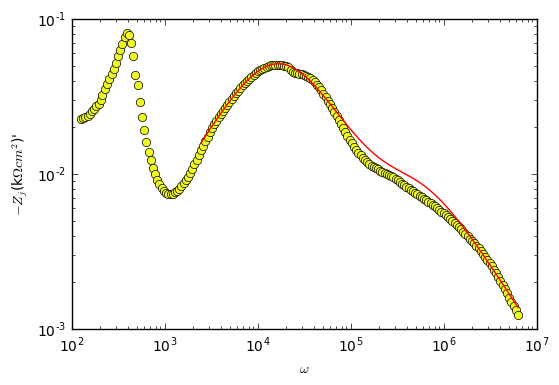

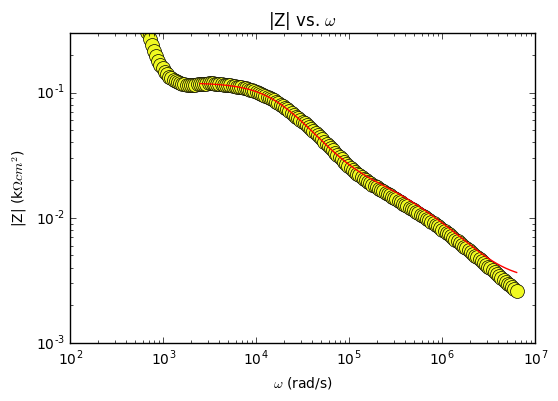

In [53]:
# now try with 3 arcs

# define a function for the impedance for total outer, double layer CPE
def cpe_dl_out(w,Q_dlo,alpha_dlo):
    return 1/(((1j*w)**alpha_dlo)*Q_dlo)

# define a function for the impedance for the series resistor for arc 1
def seriesR2(w,c2):
    return c2

# define a function for the impedance of 2 RC arcs embedded in another
def dl_3arc(w,c2,Rct1,Q1,alpha1,c1,Q_dl,alpha_dl,Q_dlo,alpha_dlo):
    return ((seriesR2(w,c2) + dl_2arc(w,Rct1,Q1,alpha1,c1,Q_dl,alpha_dl))*cpe_dl_out(w,Q_dlo,alpha_dlo)) /((seriesR2(w,c2) + dl_2arc(w,Rct1,Q1,alpha1,c1,Q_dl,alpha_dl))+cpe_dl_out(w,Q_dlo,alpha_dlo))

# define the aggregate model
RsLead = Model(seriesR,prefix = 'RsL_')
doubleLayer_3arc = Model(dl_3arc)

dlModel3arc = RsLead + doubleLayer_3arc

# add parameters with guesses
params3 = lmf.Parameters()  

params3.add('RsL_c',value =  .003, min = 0, max = 5)

params3.add('c2',value = .001, min = 0, max = 5)
params3.add('Rct1',value = guessRct2, min = 0, max = 5)
params3.add('Q1',value = 4e-4, min = 0, max = 1e-3)
params3.add('alpha1',value = 0.9, min = 0, max = 1)
params3.add('c1',value = .001, min = 0, max = 5)
params3.add('Q_dl',value = 5e-4, min = 0, max = 1e-3)
params3.add('alpha_dl',value = 0.95, min = 0, max = 1)
params3.add('Q_dlo',value = 6e-4, min = 0, max = 1e-3)
params3.add('alpha_dlo',value = 0.95, min = 0, max = 1)

# make the data complex
data = Zr400(Tt)[bounds[Tt]:]+1j*Zi400(Tt)[bounds[Tt]:]

#try the fit
fit_result3 = dlModel3arc.fit(data, w = w(Tt)[bounds[Tt]:],params = params3)

print(fit_result3.fit_report())

fit_result.plot

# make arrays that store the real and imaginary parts for the fit and the magnitude 
fitMag3 = np.sqrt((np.imag(fit_result3.best_fit))**2 + (np.real(fit_result3.best_fit))**2)
reFit3 = np.real(fit_result3.best_fit)
imFit3 = np.imag(fit_result3.best_fit)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds[Tt]:],-Zi400(Tt)[bounds[Tt]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result3.best_fit),-np.imag(fit_result3.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds[Tt]:],abs(imFit2),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds[Tt]:],fitMag3, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


All of these models seem to fit fairly equally well! 

So it seems like we can fit a double layer with a Randles, a double layer with an RC arc, and a double layer with 2 RC arcs equally well. 

To me, the most physically sensible option to try is the double layer with an RC arc in it. Not only because it returns non-trivial parameter estimates for each component of the fit (though that *is* a nice feature), but also because it has a lot of physical intuition going for it as well.

For instance, if we truly believe that there is a PbS-ZnO interface that we can detect on day 0 and day 1, then we should also have some sort of double layer capacitance that happens at the interface. Since we are forward biasing the device, we should also have charge flow through the interface, meaning that there should be a resistance associated with the PbS-ZnO interface. Becuase we have a parallel resistance and capacitance (/CPE) at the interface, we should see an RC arc.

Note that if charge is transferred through the interface, it should then be able to recombine/transport through the PbS-ZnO layer, as before. As a result, we should have a nested RC (/RQ) arc inside the outer, double layer RC (/RQ) circuit. 

We can confirm this not only by looking at ZnO only data (forthcoming...), but also running a temperature-dependent analysis of this impedance model and seeing what shakes out. If one set of the RC (/RQ) network matches what we got from the data taken in the case where we believe we have no interface, the that's a good sign this is right. 

If, however, the ZnO data contains a diffusion element or something, then we'll need more parameters. 

For now, let's tentatively see if we can get the temperature dependence of the double layer model with 2 arcs done.